# ROC 곡선과 AUC
- 의학분야에서 평가지표로 많이 사용된다.

In [32]:
# 필요한 라이브러리 import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# seaborn lib add
import seaborn as sns

from glob import glob

%matplotlib inline

import json

import warnings
warnings.filterwarnings(action = 'ignore') 

from datetime import date, datetime, timedelta
from dateutil.parser import parse

print("numpy version:",np.__version__) 
print("pandas version:",pd.__version__)

# 한글 폰트 문제 해결
import platform

from matplotlib import font_manager, rc

if platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~') 


# 차트 축 <- 음수 부호 지원
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import load_iris, load_breast_cancer

from IPython.display import Image

from sklearn.model_selection import train_test_split, KFold , StratifiedKFold, cross_val_score , cross_validate,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer, precision_recall_curve, roc_curve,roc_auc_score 
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder ,OneHotEncoder,StandardScaler, MinMaxScaler, Binarizer
import graphviz

import missingno as msno

sklearn.__version__

numpy version: 1.20.1
pandas version: 1.2.4


'0.24.1'

- FPR : 실제값이 Negetive중 Positive로 잘못 예측된 비율(건강한 사람을 질병이 있다고 판단)
- TPR : 실제값이 Positive중 Positive로 예측한 비율
- FPR이 변할때 TPR이 어떻게 변하는지 나타내는 곡선
- FPR → X축 , TPR → Y축 

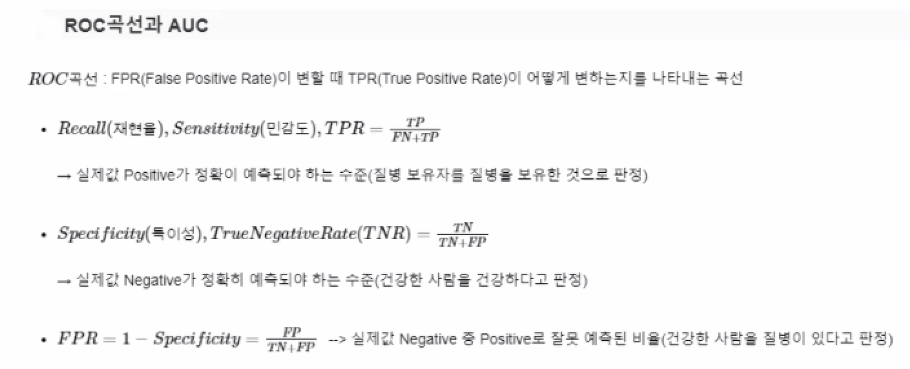

In [5]:
Image('C:/img/ROC_AUC.png')

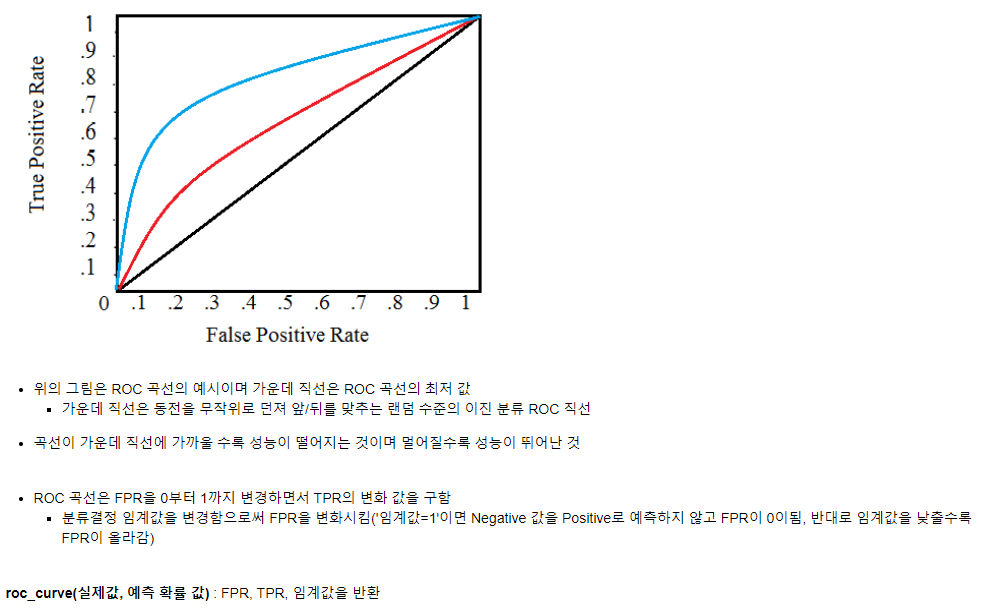

In [376]:
Image('c:/img/ROC-Curve.png' , width=700)

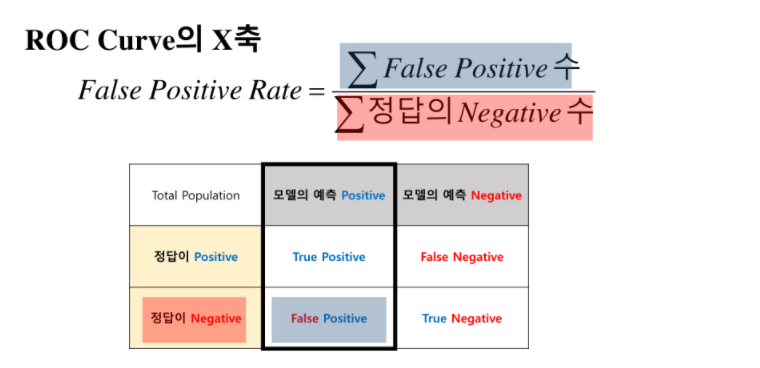

In [377]:
Image('c:\img/ROC-Curve-X.png' , width=700)

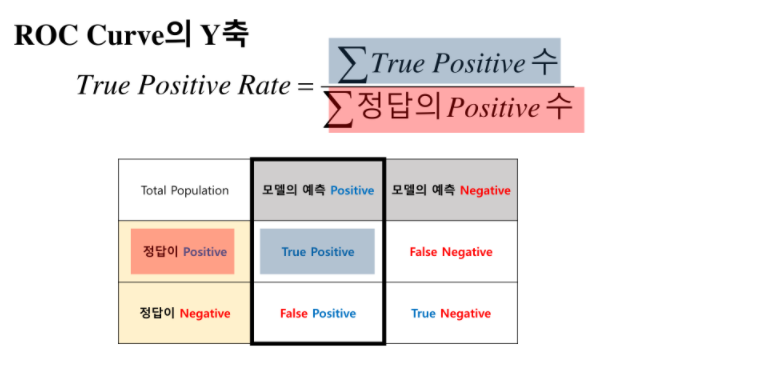

In [378]:
Image('c:\img/ROC-Curve-Y.png' , width=700)

In [6]:
titanic_frm = pd.read_csv('C:/Users/whgud/data/titanic_train.csv')
titanic_frm.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
titanic_features = titanic_frm.drop(['Survived'],axis = 1)
titanic_label = titanic_frm['Survived']
print('label type : ', type(titanic_label), 'features type : ', type(titanic_features))
titanic_features.head()

label type :  <class 'pandas.core.series.Series'> features type :  <class 'pandas.core.frame.DataFrame'>


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
# 레이블 인코딩 Cabin , Sex , Embarked
def drop_features(frm):
    frm.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return frm


def pre_processing(frm):
    frm['Age'].fillna(frm['Age'].mean(), inplace=True)
    frm['Cabin'].fillna('N', inplace=True)
    frm['Embarked'].fillna('N', inplace=True)
    return frm


def label_encoder(frm):
    frm['Cabin'] = frm['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        encoder = LabelEncoder()
        encoder.fit(frm[feature])
        frm[feature] = encoder.transform(frm[feature])
    return  frm

def transform_features(frm):
    frm = drop_features(frm)
    frm = pre_processing(frm)
    frm = label_encoder(frm)
    return frm

In [9]:
subset_features = transform_features(titanic_features)
subset_features

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,22.000000,1,0,7.2500,7,3
1,1,0,38.000000,1,0,71.2833,2,0
2,3,0,26.000000,0,0,7.9250,7,3
3,1,0,35.000000,1,0,53.1000,2,3
4,3,1,35.000000,0,0,8.0500,7,3
...,...,...,...,...,...,...,...,...
886,2,1,27.000000,0,0,13.0000,7,3
887,1,0,19.000000,0,0,30.0000,1,3
888,3,0,29.699118,1,2,23.4500,7,3
889,1,1,26.000000,0,0,30.0000,2,0


In [10]:
X_train, X_test, y_train, y_test = train_test_split(subset_features,
                                                    titanic_label,
                                                    test_size=0.2,
                                                    random_state = 100)

In [57]:
def metrics_evaluation(target, prediction):
    print('accuracy : ',accuracy_score(target, prediction))
    print('precision : ',precision_score(target, prediction))
    print('recall : ',recall_score(target, prediction))
    print('f1 score : ',f1_score(target, prediction))
    print('confusion_matrix : \n',confusion_matrix(target, prediction))
    

In [58]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

y_pred = logistic_model.predict(X_test)

In [59]:
metrics_evaluation(y_test,y_pred)

accuracy :  0.7532467532467533
precision :  0.6744186046511628
recall :  0.5471698113207547
f1 score :  0.6041666666666666
confusion_matrix : 
 [[87 14]
 [24 29]]


In [100]:
print('확률 예측값')
y_pred_prob = logistic_model.predict_proba(X_test)
y_pred_prob[:10]

확률 예측값


array([[0.83156049, 0.16843951],
       [0.93489176, 0.06510824],
       [0.28614471, 0.71385529],
       [0.87744981, 0.12255019],
       [0.55163932, 0.44836068],
       [0.30006365, 0.69993635],
       [0.02750824, 0.97249176],
       [0.88124947, 0.11875053],
       [0.1349371 , 0.8650629 ],
       [0.7708973 , 0.2291027 ]])

In [101]:
positive_y_pred_prob = logistic_model.predict_proba(X_test)[:,1]
positive_y_pred_prob

array([0.16843951, 0.06510824, 0.71385529, 0.12255019, 0.44836068,
       0.69993635, 0.97249176, 0.11875053, 0.8650629 , 0.2291027 ,
       0.10130887, 0.86404376, 0.45625361, 0.28802536, 0.72228155,
       0.33596498, 0.0938825 , 0.22183316, 0.51699427, 0.21114346,
       0.27089941, 0.01705764, 0.5398432 , 0.96729792, 0.26006937,
       0.8579546 , 0.45996562, 0.30393884, 0.50259199, 0.55685649,
       0.05126244, 0.95597593, 0.14208035, 0.57228133, 0.19149749,
       0.31542223, 0.9218725 , 0.03136102, 0.19337239, 0.34086121,
       0.3567061 , 0.81195185, 0.43698389, 0.12464863, 0.27341298,
       0.91159106, 0.09718643, 0.2397307 , 0.88440573, 0.90229281,
       0.1162285 , 0.04447513, 0.33966828, 0.74484057, 0.74344153,
       0.86723202, 0.11522844, 0.06986384, 0.79092342, 0.12688327,
       0.18204692, 0.15469791, 0.3068819 , 0.29634565, 0.39917387,
       0.26313848, 0.17184352, 0.03033691, 0.17430201, 0.03420542,
       0.04128552, 0.70268011, 0.12027897, 0.23114695, 0.20900

In [102]:
fprs, tprs, threshold = roc_curve(y_test, positive_y_pred_prob)
fprs.shape, tprs.shape, threshold.shape

((49,), (49,), (49,))

In [103]:
fprs.shape[0]

49

In [104]:
# 샘플추출작업
thr_idx = np.arange(1,threshold.shape[0],6)
print('threshold idx : \n ', threshold[thr_idx],"\n")
print('fprs idx : \n ', fprs[thr_idx],"\n")
print('tprs idx : \n ', tprs[thr_idx],"\n")

threshold idx : 
  [0.97249176 0.74484057 0.55685649 0.38536447 0.3068819  0.209002
 0.16534226 0.11522844] 

fprs idx : 
  [0.         0.04950495 0.11881188 0.22772277 0.30693069 0.47524752
 0.57425743 0.7029703 ] 

tprs idx : 
  [0.01886792 0.30188679 0.45283019 0.66037736 0.77358491 0.83018868
 0.90566038 0.96226415] 



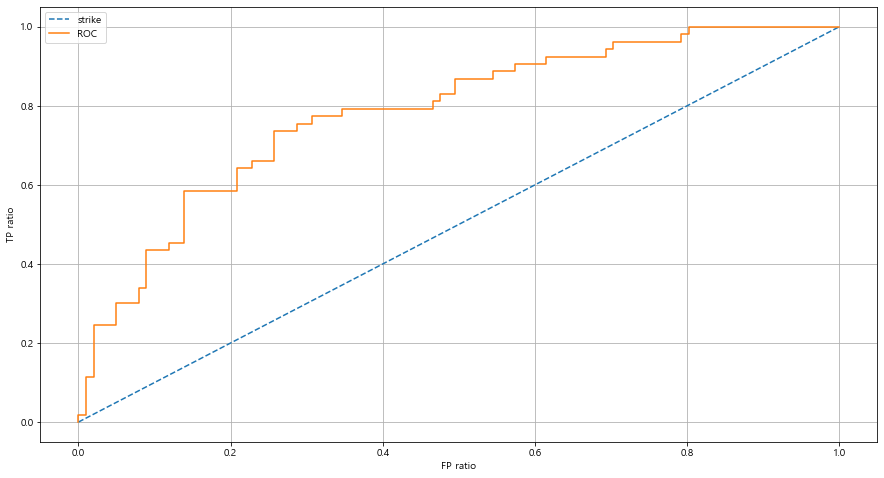

In [105]:
# 시각화

plt.figure(figsize= (15,8))

plt.plot([0,1],[0,1],linestyle = '--', label ='strike')
plt.plot(fprs,tprs,linestyle = '-', label ='ROC')

plt.xlabel('FP ratio')
plt.ylabel('TP ratio')
plt.grid()
plt.legend()
plt.show()
plt.close() # 직선에서 멀수록 성능이 좋은 것! 

In [106]:
def metrics_evaluation(target, prediction=None,prediction_prob=None):
    print('accuracy : ',accuracy_score(target, prediction))
    print('precision : ',precision_score(target, prediction))
    print('recall : ',recall_score(target, prediction))
    print('f1 score : ',f1_score(target, prediction))
    print('confusion_matrix : \n',confusion_matrix(target, prediction))
    print('roc_auc_score : ', roc_auc_score(target, prediction_prob))

In [108]:
# auc 포함된 분류모델의 성능 평가
metrics_evaluation(y_test, y_pred, positive_y_pred_prob) # shape 맞춰주기

accuracy :  0.7532467532467533
precision :  0.6744186046511628
recall :  0.5471698113207547
f1 score :  0.6041666666666666
confusion_matrix : 
 [[87 14]
 [24 29]]
roc_auc_score :  0.7829254623575566


In [109]:
y_test.shape, y_pred.shape, positive_y_pred_prob.shape

((154,), (154,), (154,))

## classifier performance measure [실습] - diabetes.csv

In [345]:
diabetes_frm = pd.read_csv("C:/Users/whgud/data/diabetes.csv")
diabetes_frm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [346]:
diabetes_frm.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 의학 관련 데이터 이므로 재현율의 지표가 중요! 

### 모델생성 (3가지)
### 전처리(결측치 , 이상치 , 표준화&정규화)
### 모델 셀렉션 , 교차검증
### 학습, 예측, 평가
### 임계값 정밀도-재현율을 확인 및 시각화
### 분포확인


### StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용하고 0값을 평균값으로 대체한 데이터 세트로 학습/예측
### 분류결정 임계값을 변경하면서 성능 측정


In [347]:
# 데이터 클린징 없이 모델 성능 예측
features = diabetes_frm.iloc[:,:-1]
target = diabetes_frm.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.2,
                                                    random_state = 156)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [348]:
# 모델생성
logistic_model = LogisticRegression()
forest_model   = RandomForestClassifier()
tree_model     = DecisionTreeClassifier()

In [349]:
logistic_model.fit(X_train,y_train)
forest_model.fit(X_train,y_train)
tree_model.fit(X_train,y_train)

DecisionTreeClassifier()

In [350]:
logistic_model_pred = logistic_model.predict(X_test)
logistic_model_prob = logistic_model.predict_proba(X_test)[:,1]

forest_model_pred = forest_model.predict(X_test)
forest_model_prob = forest_model.predict_proba(X_test)[:,1]

tree_model_pred = tree_model.predict(X_test)
tree_model_prob = tree_model.predict_proba(X_test)[:,1]


In [351]:
# 평가수행
print('logistic - evaluation')
metrics_evaluation(y_test, logistic_model_pred, logistic_model_prob)
print("*"*50)
print('forest - evaluation')
metrics_evaluation(y_test, forest_model_pred, forest_model_prob)
print("*"*50)
print('tree - evaluation')
metrics_evaluation(y_test, tree_model_pred, tree_model_prob)


logistic - evaluation
accuracy :  0.7532467532467533
precision :  0.7111111111111111
recall :  0.5614035087719298
f1 score :  0.6274509803921567
confusion_matrix : 
 [[84 13]
 [25 32]]
roc_auc_score :  0.8412009404955688
**************************************************
forest - evaluation
accuracy :  0.7597402597402597
precision :  0.7272727272727273
recall :  0.5614035087719298
f1 score :  0.6336633663366337
confusion_matrix : 
 [[85 12]
 [25 32]]
roc_auc_score :  0.8178694158075601
**************************************************
tree - evaluation
accuracy :  0.6948051948051948
precision :  0.6
recall :  0.5263157894736842
f1 score :  0.5607476635514018
confusion_matrix : 
 [[77 20]
 [27 30]]
roc_auc_score :  0.6600651112316874


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


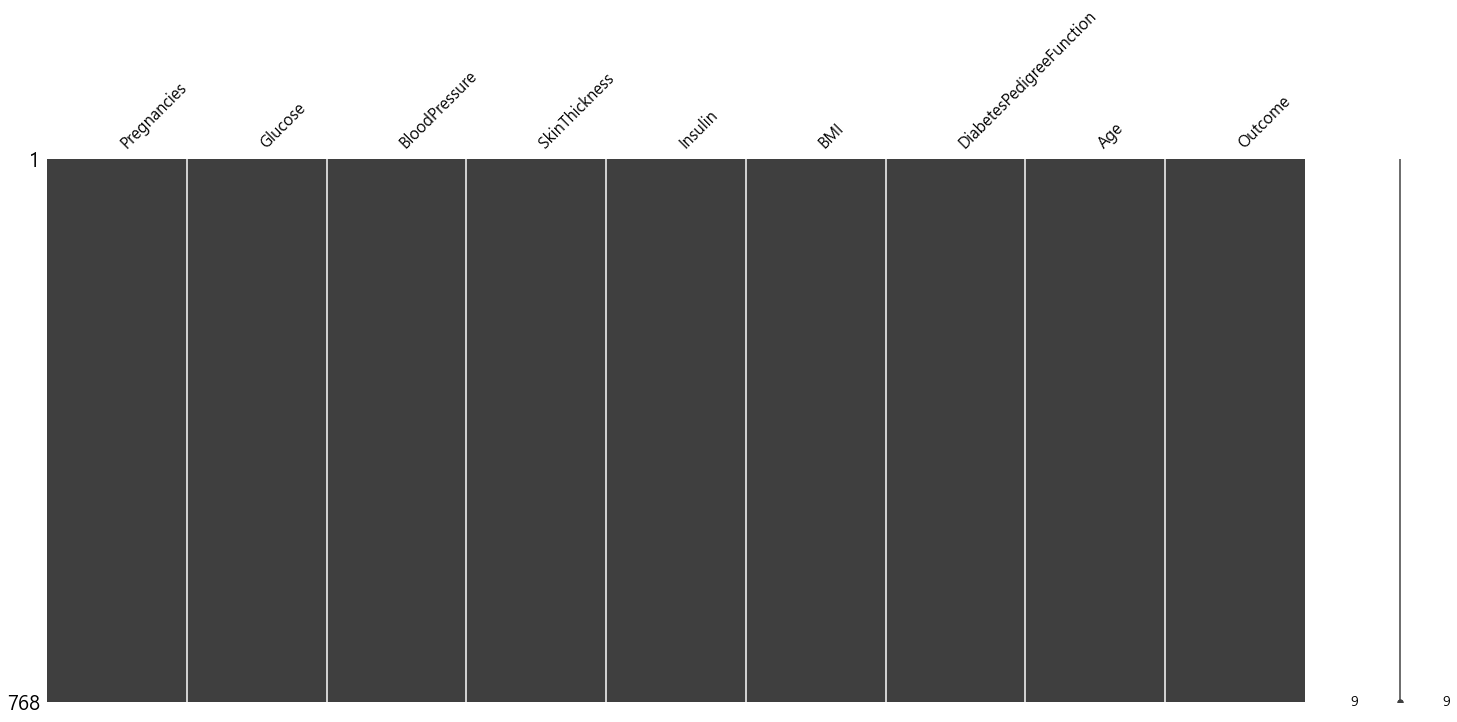

In [352]:
# 전처리(결측치 , 이상치 , 표준화&정규화)
# 결측치 확인을 위한 시각화
msno.matrix(diabetes_frm)
print(diabetes_frm.isna().sum()) # 결측값은 없음.


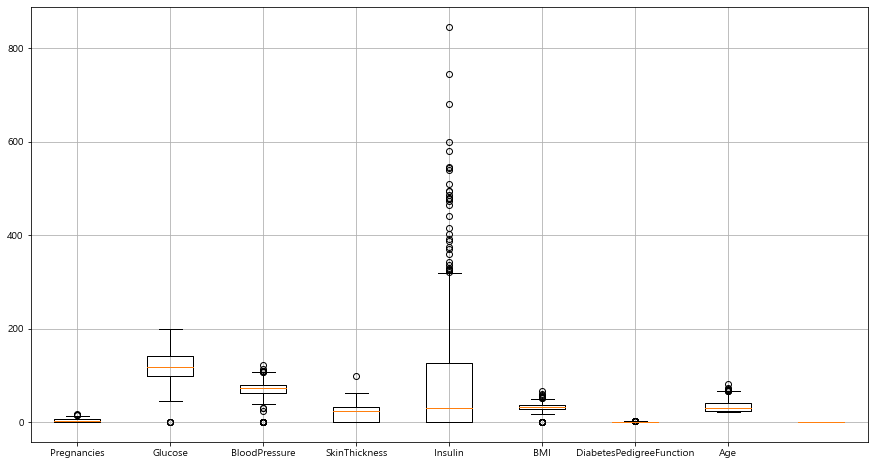

In [353]:
# 이상치 시각화

plt.figure(figsize= (15,8))


plt.boxplot(diabetes_frm)


plt.grid()
plt.xticks([1,2,3,4,5,6,7,8],diabetes_frm.iloc[:,:-1].columns)


plt.show()
plt.close()  

In [354]:
# TRAD-OFF를 확인하기 위해서 시각화하기 위한 함수
def precision_recall_plot(y_test , pred_proba) : 
    
    precisions , recalls , thresholds = precision_recall_curve(y_test , pred_proba)
    
    plt.figure(figsize = (15, 5))

    plt.plot(thresholds , precisions[0 : thresholds.shape[0]] , linestyle='--' , label = 'precision')
    plt.plot(thresholds , recalls[0 : thresholds.shape[0]]    , linestyle='-'  , label = 'recall')

    start , end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1) , 2 ))
    plt.xlabel('threshold ratio')
    plt.ylabel('precision and recall value')

    plt.grid()
    plt.legend()
    plt.show()
    plt.close()


logistic_model


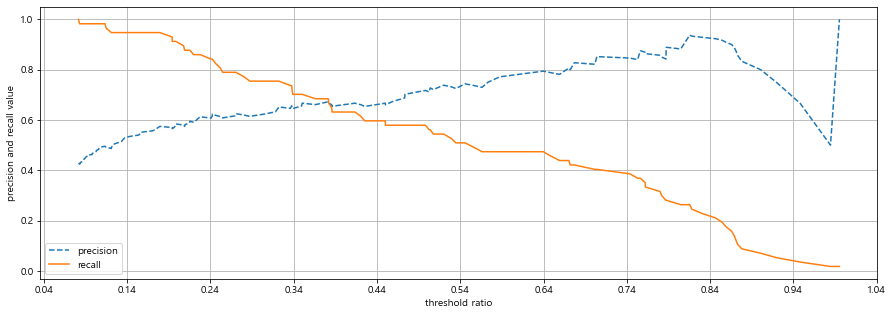

In [355]:
print('logistic_model')
precision_recall_plot(y_test,logistic_model_prob)

forest_model


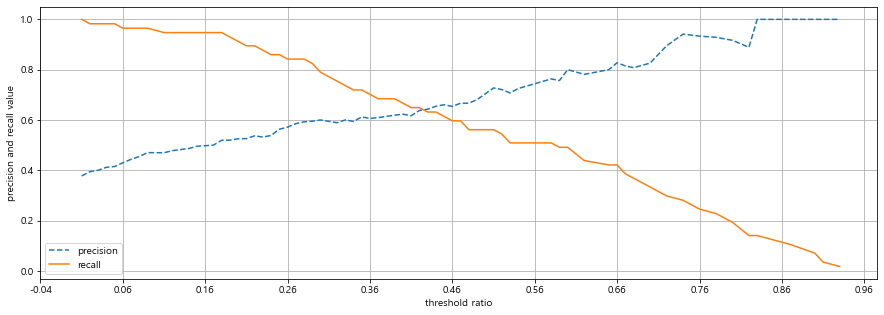

In [356]:
print('forest_model')
precision_recall_plot(y_test,forest_model_prob)

tree_model


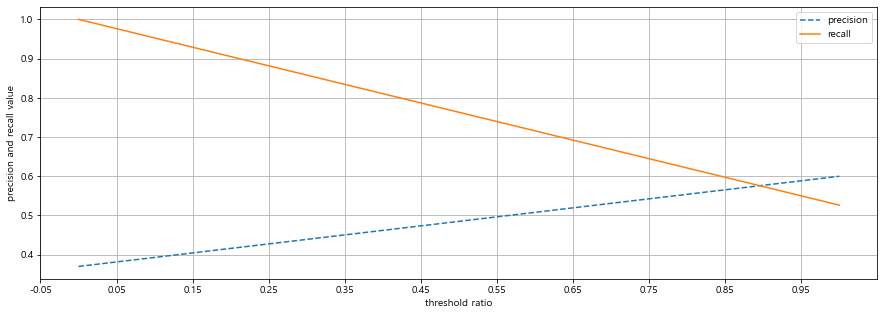

In [357]:
print('tree_model')
precision_recall_plot(y_test,tree_model_prob)

In [358]:
diabetes_frm.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [359]:
# 값이 0인 것들 확인

# 0값이 들어있는 feature들만
zero_features = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

# 전체 데이터 건수
total_count = diabetes_frm['Glucose'].count()

# 0값 비율 확인
for feature in zero_features:
    zero_count = diabetes_frm[diabetes_frm[feature]==0][feature].count()
    print('{}안의 0의 개수는 {}, 퍼센트는 {:.2f} %이다.'.format(feature, zero_count,(zero_count/total_count)*100))


Glucose안의 0의 개수는 5, 퍼센트는 0.65 %이다.
BloodPressure안의 0의 개수는 35, 퍼센트는 4.56 %이다.
SkinThickness안의 0의 개수는 227, 퍼센트는 29.56 %이다.
Insulin안의 0의 개수는 374, 퍼센트는 48.70 %이다.
BMI안의 0의 개수는 11, 퍼센트는 1.43 %이다.


In [360]:
# 값이 0인 것들 평균값으로 대체
mean_zero_features = diabetes_frm[zero_features].mean()
diabetes_frm[zero_features]=diabetes_frm[zero_features].replace(0,mean_zero_features)

diabetes_frm.describe() # 0인 값들 대체된 것 확인완료

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.681605,72.254807,26.606479,118.660163,32.450805,0.471876,33.240885,0.348958
std,3.369578,30.436016,12.115932,9.631241,93.080358,6.875374,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,20.536458,79.799479,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,79.799479,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## 결측값, 이상치 제거하는 전처리 후 모델 성능 평가

In [361]:
# 데이터 전처리 후 모델성능 예측
features = diabetes_frm.iloc[:,:-1]
target = diabetes_frm.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.2,
                                                    random_state = 156)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [362]:
### 모델 셀렉션 , 교차검증

# 모델생성
logistic_model = LogisticRegression()
forest_model   = RandomForestClassifier()
tree_model     = DecisionTreeClassifier()

logistic_model.fit(X_train,y_train)
forest_model.fit(X_train,y_train)
tree_model.fit(X_train,y_train)

DecisionTreeClassifier()

In [363]:
logistic_model_pred = logistic_model.predict(X_test)
logistic_model_prob = logistic_model.predict_proba(X_test)[:,1]

forest_model_pred = forest_model.predict(X_test)
forest_model_prob = forest_model.predict_proba(X_test)[:,1]

tree_model_pred = tree_model.predict(X_test)
tree_model_prob = tree_model.predict_proba(X_test)[:,1]

# 평가수행
print('logistic - evaluation')
metrics_evaluation(y_test, logistic_model_pred, logistic_model_prob)
print("*"*50)
print('forest - evaluation')
metrics_evaluation(y_test, forest_model_pred, forest_model_prob)
print("*"*50)
print('tree - evaluation')
metrics_evaluation(y_test, tree_model_pred, tree_model_prob)
print()
print("모델 성능 평과 결과 : logistic 모델이 가장 성능이 좋다.")

logistic - evaluation
accuracy :  0.7467532467532467
precision :  0.6956521739130435
recall :  0.5614035087719298
f1 score :  0.6213592233009708
confusion_matrix : 
 [[83 14]
 [25 32]]
roc_auc_score :  0.8299873394827274
**************************************************
forest - evaluation
accuracy :  0.7467532467532467
precision :  0.7045454545454546
recall :  0.543859649122807
f1 score :  0.613861386138614
confusion_matrix : 
 [[84 13]
 [26 31]]
roc_auc_score :  0.8080122987882076
**************************************************
tree - evaluation
accuracy :  0.6688311688311688
precision :  0.5535714285714286
recall :  0.543859649122807
f1 score :  0.5486725663716814
confusion_matrix : 
 [[72 25]
 [26 31]]
roc_auc_score :  0.6430638451799602

모델 성능 평과 결과 : logistic 모델이 가장 성능이 좋다.


In [364]:
# 교차검증
# kfold교차검증을 위한 함수 생성
def def_kfold(clf, folds):
    cv_accuracy=[]
    kfold = KFold(n_splits=folds)

    n_iter=0
    for train_idx, test_idx in kfold.split(titanic_features):
    #     print('train_idx : ',train_idx)
    #     print('test_idx : ',test_idx)
            X_train, X_val = titanic_features.values[train_idx], titanic_features.values[test_idx]
            y_train, y_val = titanic_label.values[train_idx], titanic_label.values[test_idx]

            # 학습과 예측
            clf.fit(X_train,y_train)
            clf_pred = clf.predict(X_val)

            n_iter += 1

            #학습 데이터에 대한 검증 정확도 측정
            acc = accuracy_score(y_val, clf_pred)
            print('{} 교차검증 정확도 : {}, 학습 데이터 크기 : {}, 검증데이터 크기 : {}'.format(n_iter, acc, X_train.shape[0],X_val.shape[0]))

            cv_accuracy.append(acc)
    print('교차검증 평균 정확도 : ', np.mean(cv_accuracy))

In [365]:
# 각 모델별로 교차검증
print('logistic_model kfold 교차검증')
def_kfold(logistic_model, 5)
print('\n', 'forest_model kfold 교차검증')
def_kfold(forest_model, 5)
print('\n', 'tree_model kfold 교차검증')
def_kfold(tree_model, 5)
print()
print('kfold 교차검증시엔 forest > logistic > tree 모델 순으로 정확도가 높다')

logistic_model kfold 교차검증
1 교차검증 정확도 : 0.7988826815642458, 학습 데이터 크기 : 712, 검증데이터 크기 : 179
2 교차검증 정확도 : 0.7808988764044944, 학습 데이터 크기 : 713, 검증데이터 크기 : 178
3 교차검증 정확도 : 0.7752808988764045, 학습 데이터 크기 : 713, 검증데이터 크기 : 178
4 교차검증 정확도 : 0.7584269662921348, 학습 데이터 크기 : 713, 검증데이터 크기 : 178
5 교차검증 정확도 : 0.8202247191011236, 학습 데이터 크기 : 713, 검증데이터 크기 : 178
교차검증 평균 정확도 :  0.7867428284476806

 forest_model kfold 교차검증
1 교차검증 정확도 : 0.7653631284916201, 학습 데이터 크기 : 712, 검증데이터 크기 : 179
2 교차검증 정확도 : 0.8146067415730337, 학습 데이터 크기 : 713, 검증데이터 크기 : 178
3 교차검증 정확도 : 0.8258426966292135, 학습 데이터 크기 : 713, 검증데이터 크기 : 178
4 교차검증 정확도 : 0.7696629213483146, 학습 데이터 크기 : 713, 검증데이터 크기 : 178
5 교차검증 정확도 : 0.848314606741573, 학습 데이터 크기 : 713, 검증데이터 크기 : 178
교차검증 평균 정확도 :  0.804758018956751

 tree_model kfold 교차검증
1 교차검증 정확도 : 0.7374301675977654, 학습 데이터 크기 : 712, 검증데이터 크기 : 179
2 교차검증 정확도 : 0.7696629213483146, 학습 데이터 크기 : 713, 검증데이터 크기 : 178
3 교차검증 정확도 : 0.7921348314606742, 학습 데이터 크기 : 713, 검증데이터 크기 : 178
4 교차검증 정확도 : 

In [366]:
# cross_val_score()를 활용한 교차검증


print('LogisticRegression모델 교차검증')
print('성능평가지표:accuracy, 교차검증 5회 수행시')
scores_l = cross_val_score(logistic_model,features,target,scoring='accuracy',cv=5)
print(scores_l)
print(' 평균 검증 정확도 : ',np.round(np.mean(scores_l),3))
print()

print('RandomForestClassifier모델 교차검증')
print('성능평가지표:accuracy, 교차검증 5회 수행시')
scores_r = cross_val_score(forest_model,features,target,scoring='accuracy', cv=5)
print(scores_r)
print(' 평균 검증 정확도 : ',np.round(np.mean(scores_r),3))
print()


print('DecisionTreeClassifier모델 교차검증')
print('성능평가지표:accuracy, 교차검증 5회 수행시')
scores_d = cross_val_score(tree_model,features,target,scoring='accuracy', cv=5)
print(scores_d)
print(' 평균 검증 정확도 : ',np.round(np.mean(scores_d),3))
print()


LogisticRegression모델 교차검증
성능평가지표:accuracy, 교차검증 5회 수행시
[0.74675325 0.77272727 0.74675325 0.82352941 0.75816993]
 평균 검증 정확도 :  0.77

RandomForestClassifier모델 교차검증
성능평가지표:accuracy, 교차검증 5회 수행시
[0.72727273 0.72077922 0.75324675 0.83660131 0.74509804]
 평균 검증 정확도 :  0.757

DecisionTreeClassifier모델 교차검증
성능평가지표:accuracy, 교차검증 5회 수행시
[0.68831169 0.68831169 0.66233766 0.75163399 0.74509804]
 평균 검증 정확도 :  0.707



logistic_model


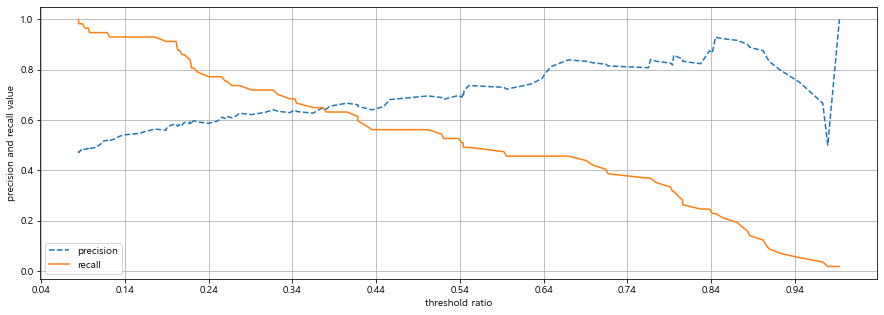

In [367]:
print('logistic_model')
precision_recall_plot(y_test,logistic_model_prob)

In [368]:
# 임계값을 재조정하여 예측수행

user_th=0.41
predict_proba_positive = logistic_model_prob.reshape(-1,1)
user_pred = Binarizer(threshold = user_th).fit_transform(predict_proba_positive)

In [369]:
def change_threshold_eval(y_test, logistic_model_prob, threshold_list):
    for user_th in threshold_list:
        user_pred = Binarizer(threshold = user_th).fit_transform(logistic_model_prob)
        print('threshold가 '+ str(user_th) + '일때')
        metrics_evaluation(y_test, user_pred, logistic_model_prob)
        print()

In [370]:
threshold_list = [0.34,0.36,0.39,0.41,0.45,0.49,0.53]
pred_proba = logistic_model.predict_proba(X_test)
change_threshold_eval(y_test,pred_proba[:,1].reshape(-1,1), threshold_list)

threshold가 0.34일때
accuracy :  0.6298701298701299
precision :  0.0
recall :  0.0
f1 score :  0.0
confusion_matrix : 
 [[97  0]
 [57  0]]
roc_auc_score :  0.22173991680231508

threshold가 0.36일때
accuracy :  0.6298701298701299
precision :  0.0
recall :  0.0
f1 score :  0.0
confusion_matrix : 
 [[97  0]
 [57  0]]
roc_auc_score :  0.22173991680231508

threshold가 0.39일때
accuracy :  0.6298701298701299
precision :  0.0
recall :  0.0
f1 score :  0.0
confusion_matrix : 
 [[97  0]
 [57  0]]
roc_auc_score :  0.22173991680231508

threshold가 0.41일때
accuracy :  0.6298701298701299
precision :  0.0
recall :  0.0
f1 score :  0.0
confusion_matrix : 
 [[97  0]
 [57  0]]
roc_auc_score :  0.22173991680231508

threshold가 0.45일때
accuracy :  0.6298701298701299
precision :  0.0
recall :  0.0
f1 score :  0.0
confusion_matrix : 
 [[97  0]
 [57  0]]
roc_auc_score :  0.22173991680231508

threshold가 0.49일때
accuracy :  0.6298701298701299
precision :  0.0
recall :  0.0
f1 score :  0.0
confusion_matrix : 
 [[97  0]
 [57

## feature scaling 적용해보기

In [371]:
features = diabetes_frm.iloc[:,:-1]
target = diabetes_frm.iloc[:,-1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler=StandardScaler()
s_features= scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(s_features,
                                                    target,
                                                    test_size=0.2,
                                                    random_state = 156)

logistic_model = LogisticRegression()
logistic_model.fit(X_train,y_train)
pred = logistic_model.predict(X_test)
pred_proba = logistic_model.predict_proba(X_test)[:,1]
metrics_evaluation(y_test, pred, pred_proba)

accuracy :  0.7467532467532467
precision :  0.6956521739130435
recall :  0.5614035087719298
f1 score :  0.6213592233009708
confusion_matrix : 
 [[83 14]
 [25 32]]
roc_auc_score :  0.8319768493398444


In [373]:
threshold_list = [0.34,0.36,0.39,0.41,0.45,0.49,0.53]
pred_proba = logistic_model.predict_proba(X_test)
change_threshold_eval(y_test,pred_proba[:,1].reshape(-1,1), threshold_list)

threshold가 0.34일때
accuracy :  0.7337662337662337
precision :  0.6333333333333333
recall :  0.6666666666666666
f1 score :  0.6495726495726496
confusion_matrix : 
 [[75 22]
 [19 38]]
roc_auc_score :  0.8319768493398444

threshold가 0.36일때
accuracy :  0.7272727272727273
precision :  0.6271186440677966
recall :  0.6491228070175439
f1 score :  0.6379310344827587
confusion_matrix : 
 [[75 22]
 [20 37]]
roc_auc_score :  0.8319768493398444

threshold가 0.39일때
accuracy :  0.7467532467532467
precision :  0.6666666666666666
recall :  0.631578947368421
f1 score :  0.6486486486486486
confusion_matrix : 
 [[79 18]
 [21 36]]
roc_auc_score :  0.8319768493398444

threshold가 0.41일때
accuracy :  0.7402597402597403
precision :  0.660377358490566
recall :  0.6140350877192983
f1 score :  0.6363636363636364
confusion_matrix : 
 [[79 18]
 [22 35]]
roc_auc_score :  0.8319768493398444

threshold가 0.45일때
accuracy :  0.7337662337662337
precision :  0.6666666666666666
recall :  0.5614035087719298
f1 score :  0.609523

## 결론 :  임계값이 0.39일때가 전체적인 성능평가지표를 유지하면서 재현율을 약간 향상시키는 좋은 임계값으로 보인다.

In [375]:
# 임계값을 0.39로 설정한 BInarizer 생성
binarizer = Binarizer(threshold=0.39)
pred_th_039 = binarizer.fit_transform(pred_proba[:,1].reshape(-1,1))
metrics_evaluation(y_test, pred_th_039, pred_proba[:,1])

accuracy :  0.7467532467532467
precision :  0.6666666666666666
recall :  0.631578947368421
f1 score :  0.6486486486486486
confusion_matrix : 
 [[79 18]
 [21 36]]
roc_auc_score :  0.8319768493398444
